In [1]:
import sys, os


import networkx as nx
from geopy.distance import great_circle
import geohash
import geopandas as gpd
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import contextily as cx
from shapely.geometry import Polygon,Point
from shapely import wkt,ops
import colorsys
from sklearn.preprocessing import StandardScaler
from scipy import spatial
import random

In [2]:
from io import BytesIO
import palettable

In [3]:

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.sans-serif'] = ['Arial'] + ['DejaVu Sans',
                              'Bitstream Vera Sans',
                              'Computer Modern Sans Serif',
                              'Lucida Grande',
                              'Verdana',
                              'Geneva',
                              'Lucid',
                              'Arial',
                              'Helvetica',
                              'Avant Garde',
                              'sans-serif']

In [6]:
country_name = 'colombia'
country_abbrv = 'co'

In [7]:
daily_od_fname = f'od_{country_abbrv}_agg5_3h.csv'
daily_od = pd.read_csv(daily_od_fname)
geohashes = list(set(daily_od.start_geohash5.unique()).union(set(daily_od.end_geohash5.unique())))
geohash_coord = {gh:geohash.decode(gh) for gh in geohashes}
geohash_bbox = {gh: geohash.bbox(gh) for gh in geohashes}

/home/jupyter-niyer/README
niyer SunSquare1!


In [8]:
unique_times = list(np.unique([row.local_time[-19:] for i, row in daily_od.iterrows()]))
str_time_dict = {t:i for i, t in enumerate(unique_times)}
daily_od['time_id'] = daily_od.local_time.apply(lambda x: str_time_dict[x[-19:]])
daily_od['m_length_km'] = daily_od.m_length_m/1000.
daily_od['neighbours'] = daily_od['start_geohash5'].apply(lambda x: geohash.neighbors(x))


In [ ]:
urbanicity_df = pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')

# Efficiency Inequality

## Get the weighted average length of trips from the empirical origin destination matrix

In [10]:
daily_od['wtd_length'] = daily_od['m_length_m'] * daily_od['trip_count']
R = daily_od.groupby(['start_geohash5', 'end_geohash5', 'time_id']).agg({'trip_count':'mean',
                                                                            'wtd_length':'mean'}).reset_index()
    
R['trip_count'] = R['trip_count'].round().astype(int)

R['avg_len_real'] = R['wtd_length']/R['trip_count']
R['short'] = R['avg_len_real'].apply(lambda x: x<=5000)
R

,start_geohash5,end_geohash5,time_id,trip_count,wtd_length,avg_len_real,short
0,d0rfr,d0rfr,2,15,155694.840155,10379.656010,False
1,d0rfr,d0rfr,3,16,34268.598823,2141.787426,True
2,d0rfr,d0rfr,4,15,31539.753607,2102.650240,True
3,d0rfr,d0rfr,5,19,45297.433983,2384.075473,True
4,d0rfr,d0rfr,6,15,29173.206005,1944.880400,True
...,...,...,...,...,...,...,...
4684,d9050,d9050,3,12,24519.187908,2043.265659,True
4685,d9050,d9050,4,13,18241.451971,1403.188613,True
4686,d9050,d9050,5,11,17105.166036,1555.015094,True
4687,d9050,d9050,6,10,38151.952298,3815.195230,True


## Get the weighted average length for 'shortest-path', incorporating weights from empirical OD

In [53]:
weekday_eff = pd.read_csv('estimated_routes/'+country_abbrv+'_agg_weekday_eff.csv')

/home/jupyter-niyer/README
niyer SunSquare1!
/home/jupyter-niyer/README
niyer SunSquare1!


In [54]:
weekday_eff

,start_geohash5,end_geohash5,local_date,time_id,origin,destination,iteration,sp_lengths
0,d20u9,d20u9,agg,0,7692637761,9326680035,0,3163.336
1,d20u9,d20u9,agg,0,9393650050,3768318908,0,2188.884
2,d20u9,d20u9,agg,0,3752220648,2545461564,0,3159.812
3,d20u9,d20u9,agg,0,10917589173,7692591328,0,642.381
4,d20u9,d20u9,agg,0,9284884168,7711073001,0,3170.437
...,...,...,...,...,...,...,...,...
8957495,d9050,d9050,agg,7,1166883621,6471516225,99,1314.722
8957496,d9050,d9050,agg,7,1166883245,8433599041,99,3173.063
8957497,d9050,d9050,agg,7,1166883533,7767844407,99,1794.107
8957498,d9050,d9050,agg,7,1166883676,1879366310,99,1977.144


In [55]:
weekday_eff = weekday_eff.groupby(['start_geohash5', 'end_geohash5', 'time_id', 'iteration']).agg({'sp_lengths':'mean',
                                                                                                   'origin':'count'}, axis=1).reset_index()

In [56]:
weekday_eff = weekday_eff.groupby(['start_geohash5', 'end_geohash5', 'time_id']).agg({'sp_lengths':'mean',
                                                                                     'origin':'first'}, axis=1).reset_index()

In [57]:
weekday_eff = weekday_eff.merge(urbanicity_df, how='left', left_on='start_geohash5', right_on='gh5')

In [58]:
weekday_eff = weekday_eff.merge(R, how='left', on=['start_geohash5'	,'end_geohash5',	'time_id'],  suffixes=['_est', '_real'])

In [59]:
weekday_eff['short_est'] = weekday_eff['sp_lengths'].apply(lambda x: x<=5000)
weekday_eff['short_real'] = weekday_eff['avg_len_real'].apply(lambda x: x<=5000)


In [60]:
weekday_eff['delta'] = weekday_eff['avg_len_real'] - weekday_eff['sp_lengths']

In [61]:
weekday_eff

,start_geohash5,end_geohash5,time_id,sp_lengths,origin,gh5,cluster_id,area_type,closest_city,trip_count,wtd_length,avg_len_real,short,short_est,short_real,delta
0,d0rfr,d0rfr,2,1925.927613,16,d0rfr,NaN,neither,NaN,15,155694.840155,10379.656010,False,True,False,8453.728397
1,d0rfr,d0rfr,3,1924.781782,16,d0rfr,NaN,neither,NaN,16,34268.598823,2141.787426,True,True,True,217.005644
2,d0rfr,d0rfr,4,1951.107792,16,d0rfr,NaN,neither,NaN,15,31539.753607,2102.650240,True,True,True,151.542449
3,d0rfr,d0rfr,5,1984.880159,20,d0rfr,NaN,neither,NaN,19,45297.433983,2384.075473,True,True,True,399.195313
4,d0rfr,d0rfr,6,1908.476843,15,d0rfr,NaN,neither,NaN,15,29173.206005,1944.880400,True,True,True,36.403558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4265,d6hde,d6hde,6,2056.683347,13,d6hde,NaN,neither,NaN,12,31760.384749,2646.698729,True,True,True,590.015382
4266,d9050,d9050,3,1496.193987,11,d9050,NaN,neither,NaN,12,24519.187908,2043.265659,True,True,True,547.071672
4267,d9050,d9050,4,1546.647004,13,d9050,NaN,neither,NaN,13,18241.451971,1403.188613,True,True,True,-143.458391
4268,d9050,d9050,5,1545.744178,11,d9050,NaN,neither,NaN,11,17105.166036,1555.015094,True,True,True,9.270916


In [62]:
time_str_dict = {v:k for k,v in str_time_dict.items()}

In [63]:
from io import BytesIO
from scipy.stats import ks_2samp

In [15]:
urbanicity_df = pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')

/home/jupyter-niyer/README
niyer SunSquare1!


/tmp/ipykernel_547803/568262666.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i][0].set_xticklabels(['', '','-2500','0','2500','',''], fontsize=18, color='white')
/tmp/ipykernel_547803/568262666.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i][1].set_xticklabels(['', '-5000','','5000','','15000'], fontsize=18, color='white')
/tmp/ipykernel_547803/568262666.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i][0].set_xticklabels(['', '','-2500','0','2500','',''], fontsize=18, color='white')
/tmp/ipykernel_547803/568262666.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i][1].set_xticklabels(['', '-5000','','5000','',

/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/co_mob_ineff_trip_dist_temporal.pdf' to bucket 'niyer-processed'.


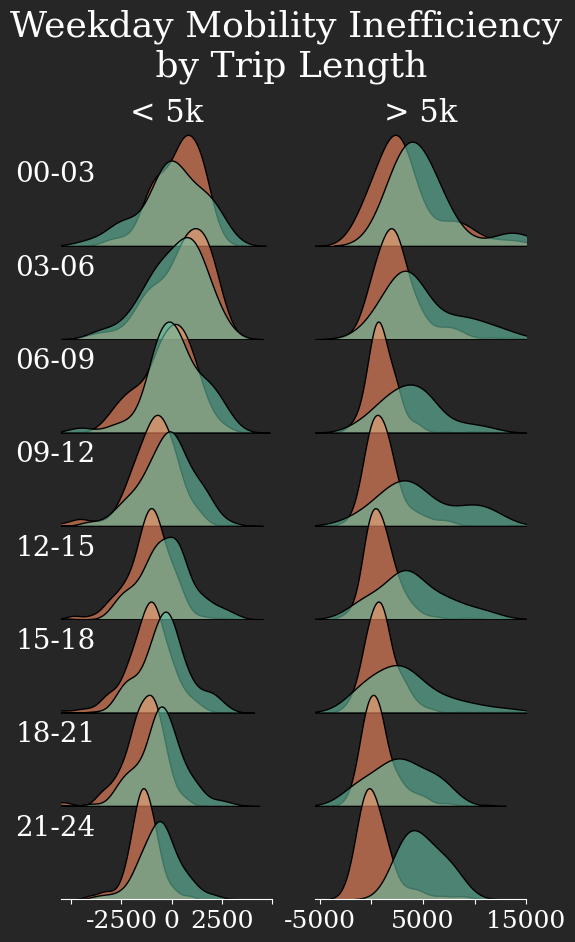

In [468]:
fig, axes=plt.subplots(8,2,figsize=(6,10))
for i in range(8):
    
    ax = axes[i][0]
    sns.kdeplot(data=weekday_eff[
                 (weekday_eff.short_real==True) &
                  (weekday_eff.time_id==i)], x='delta', hue='area_type', hue_order=['rural','urban'],
                common_norm=False , ax=ax, palette='Set2', alpha=0.6, legend=False,
               fill=True, edgecolor='k')

    ax.set_xlim((-5500,5000))
    ax.get_yaxis().set_ticks([])
    lbl = time_str_dict[i]
    ax.set_ylabel(lbl[:2] + '-' + lbl[11:13], fontsize=20, rotation=0, x=0.1, color='white')
    
    
    ax = axes[i][1]
    sns.kdeplot(data=weekday_eff[
                 (weekday_eff.short_real==False) &
                  (weekday_eff.time_id==i)], x='delta', hue='area_type', hue_order=['rural','urban'],
                common_norm=False , ax=ax, palette='Set2', alpha=0.6, legend=False,
               fill=True, edgecolor='k')
    ax.set_xlim((-5500,15000))
    for ax in axes[i]:
        ax.patch.set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlabel('')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')

        if i==0:
            axes[i][0].set_title('< 5k', fontsize=22, color='white')
            axes[i][1].set_title('> 5k', fontsize=22, color='white')
        if i<7:
            ax.get_xaxis().set_ticks([])
        else:
            ax.spines['bottom'].set_visible(True)
            ax.spines['bottom'].set_color('white')
            axes[i][0].set_xticklabels(['', '','-2500','0','2500','',''], fontsize=18, color='white')
            axes[i][1].set_xticklabels(['', '-5000','','5000','','15000'], fontsize=18, color='white')
    ax.get_yaxis().set_ticks([])
    ax.set_ylabel('')
plt.subplots_adjust(hspace=-0.2, wspace=0.2)
fig.patch.set_facecolor('#262626')
fig.suptitle('Weekday Mobility Inefficiency\n by Trip Length', fontsize=26, y=1.0, color='white')

buf = BytesIO()
plt.savefig(buf, format='pdf')
buf.seek(0)
minio_helper.save_file(f'final_figures/processing/{country_abbrv}_mob_ineff_trip_dist_temporal.pdf', buf, obj_type='image')

In [17]:
from scipy.stats import ks_2samp,mannwhitneyu,entropy,anderson_ksamp


In [ ]:
mob_ineff_diff = []
for country_abbrv in ['co', 'mx', 'in']:
    #### DEFINE REAL #####
    daily_od_fname = f'od_{country_abbrv}_agg5_3h.csv'
    daily_od = pd.read_csv(daily_od_fname)
    geohashes = list(set(daily_od.start_geohash5.unique()).union(set(daily_od.end_geohash5.unique())))
    geohash_coord = {gh:geohash.decode(gh) for gh in geohashes}
    geohash_bbox = {gh: geohash.bbox(gh) for gh in geohashes}
    unique_times = list(np.unique([row.local_time[-19:] for i, row in daily_od.iterrows()]))
    str_time_dict = {t:i for i, t in enumerate(unique_times)}
    daily_od['time_id'] = daily_od.local_time.apply(lambda x: str_time_dict[x[-19:]])
    daily_od['m_length_km'] = daily_od.m_length_m/1000.
    daily_od['neighbours'] = daily_od['start_geohash5'].apply(lambda x: geohash.neighbors(x))
    daily_od['wtd_length'] = daily_od['m_length_m'] * daily_od['trip_count']
    R = daily_od.groupby(['start_geohash5', 'end_geohash5', 'time_id']).agg({'trip_count':'mean',
                                                                                'wtd_length':'mean'}).reset_index()
        
    R['trip_count'] = R['trip_count'].round().astype(int)
    
    R['avg_len_real'] = R['wtd_length']/R['trip_count']
    R['short'] = R['avg_len_real'].apply(lambda x: x<=5000)

    ##### DEFINE ESTIMATED
    weekday_eff = pd.read_csv('estimated_routes/'+country_abbrv+'_agg_weekday_eff.csv')
    urbanicity_df = pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')

    weekday_eff = weekday_eff.groupby(['start_geohash5', 'end_geohash5', 'time_id', 'iteration']).agg({'sp_lengths':'mean',
                                                                                                   'origin':'count'}, axis=1).reset_index()
    weekday_eff = weekday_eff.groupby(['start_geohash5', 'end_geohash5', 'time_id']).agg({'sp_lengths':'mean',
                                                                                     'origin':'first'}, axis=1).reset_index()
    weekday_eff = weekday_eff.merge(urbanicity_df, how='left', left_on='start_geohash5', right_on='gh5')
    weekday_eff = weekday_eff.merge(R, how='left', on=['start_geohash5'	,'end_geohash5',	'time_id'],  suffixes=['_est', '_real'])
    weekday_eff['short_est'] = weekday_eff['sp_lengths'].apply(lambda x: x<=5000)
    weekday_eff['short_real'] = weekday_eff['avg_len_real'].apply(lambda x: x<=5000)
    weekday_eff['delta'] = weekday_eff['avg_len_real'] - weekday_eff['sp_lengths']

    for i in range(8):
    
        
        weekday_short_urban = weekday_eff[(weekday_eff.short_real==True) &
                                                (weekday_eff.time_id==i) & (weekday_eff.area_type=='urban')].delta
        weekday_short_rural = weekday_eff[(weekday_eff.short_real==True) &
                                                (weekday_eff.time_id==i) & (weekday_eff.area_type=='rural')].delta
        print('short', ks_2samp(weekday_short_urban, weekday_short_rural), i)
        ks_short = ks_2samp(weekday_short_urban, weekday_short_rural)
        mob_ineff_diff += [['short', ks_short.statistic, ks_short.pvalue, i, country_abbrv]]
        
        weekday_long_urban = weekday_eff[(weekday_eff.short_real==False) &
                                                (weekday_eff.time_id==i) & (weekday_eff.area_type=='urban')].delta
        weekday_long_rural = weekday_eff[(weekday_eff.short_real==False) &
                                                (weekday_eff.time_id==i) & (weekday_eff.area_type=='rural')].delta
        print('long', ks_2samp(weekday_long_urban, weekday_long_rural), i)
        ks_long = ks_2samp(weekday_long_urban, weekday_long_rural)
        mob_ineff_diff += [['long', ks_long.statistic, ks_long.pvalue, i, country_abbrv]]
        print()
mob_ineff_diff = pd.DataFrame(mob_ineff_diff, columns=['trip_type', 'ks_stat', 'ks_pval', 'time_id', 'country_abbrv'])
mob_ineff_diff

In [70]:
mob_ineff_diff

,trip_type,ks_stat,ks_pval,time_id,country_abbrv,bonferroni_threshold,significant_bonferroni
0,short,0.279245,3.495626e-02,0,co,0.001042,False
1,long,0.371242,5.001803e-02,0,co,0.001042,False
2,short,0.262821,1.219954e-01,1,co,0.001042,False
3,long,0.398601,3.198676e-03,1,co,0.001042,False
4,short,0.123648,1.768646e-01,2,co,0.001042,False
5,long,0.389632,8.412039e-06,2,co,0.001042,True
6,short,0.297966,1.508753e-08,3,co,0.001042,True
7,long,0.431982,5.889202e-07,3,co,0.001042,True
8,short,0.346380,1.620636e-12,4,co,0.001042,True
9,long,0.395815,7.899216e-05,4,co,0.001042,True


In [39]:
import palettable


In [45]:
pal = sns.color_palette(palettable.cartocolors.qualitative.Antique_4.hex_colors[:2] + palettable.cartocolors.qualitative.Antique_4.hex_colors[2:3])

In [47]:
pal = sns.color_palette(palettable.cartocolors.qualitative.Bold_3.hex_colors)

In [51]:
time_str_dict

{0: '00:00:00 - 03:00:00',
 1: '03:00:00 - 06:00:00',
 2: '06:00:00 - 09:00:00',
 3: '09:00:00 - 12:00:00',
 4: '12:00:00 - 15:00:00',
 5: '15:00:00 - 18:00:00',
 6: '18:00:00 - 21:00:00',
 7: '21:00:00 - 24:00:00'}

/home/jupyter-niyer/README
[Text(0, 0.0, '0'), Text(0, 20.0, '20'), Text(0, 40.0, '40'), Text(0, 60.0, '60'), Text(0, 80.0, '80'), Text(0, 100.0, '100'), Text(0, 120.0, '120')]
/home/jupyter-niyer/README


/tmp/ipykernel_2447848/2312501481.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_2447848/2312501481.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
/tmp/ipykernel_2447848/2312501481.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_2447848/2312501481.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '','100','','200','','300'], fontsize=14)


[Text(0, 0.0, '0'), Text(0, 100.0, '100'), Text(0, 200.0, '200'), Text(0, 300.0, '300'), Text(0, 400.0, '400')]
/home/jupyter-niyer/README
[Text(0, 0.0, '0'), Text(0, 100.0, '100'), Text(0, 200.0, '200'), Text(0, 300.0, '300'), Text(0, 400.0, '400')]


/tmp/ipykernel_2447848/2312501481.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/tmp/ipykernel_2447848/2312501481.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)


/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/agg_delta_distr.pdf' to bucket 'niyer-processed'.


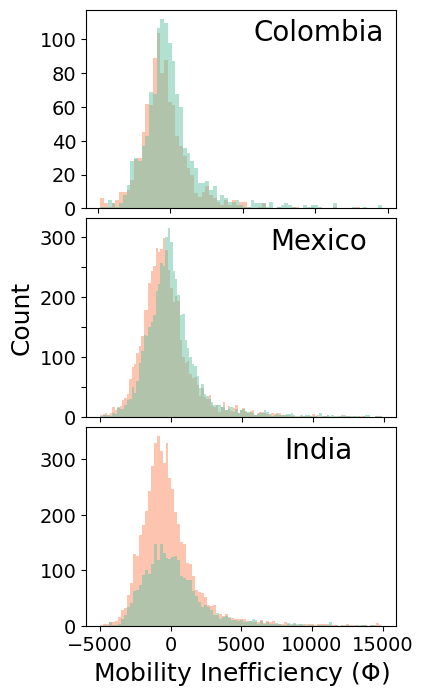

In [64]:
fig,axes = plt.subplots(3,1,figsize=(4,8))
all_mob_eff = []
for i,ca in enumerate(['co', 'mx', 'in']):

    mob_eff = pd.read_csv('estimated_routes/'+ca+'_agg_weekday_eff.csv')
    mob_eff = mob_eff[mob_eff.area_type.isin(['urban', 'rural'])]
    mob_eff['cat'] = ca+'_'+mob_eff.area_type
    all_mob_eff.append(mob_eff)
    ax=axes[i]
    ax.set_title(abbrv_title[ca], fontsize=20, y=0.8, x=0.75)
    sns.histplot(data=mob_eff, x='delta', ax=ax, hue='area_type', hue_order=['rural','urban'], palette='Set2', legend=False, edgecolor='none')

    prin
    ax.set_xlabel(r'Mobility Inefficiency ($\Phi$)', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    print(ax.get_yticklabels())
    if ca == 'mx':
        ax.set_yticklabels(['0', '','100','','200','','300'], fontsize=14)
    else:
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    if i!= 1:
        ax.set_ylabel('')
    if i <2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
fig.subplots_adjust(hspace=0.05)
all_mob_eff = pd.concat(all_mob_eff)